In [55]:
import numpy as np
from itertools import chain, combinations
from math import factorial
import torch

def mask_features_with_mean(X, fixed_features, baseline = 'graph', GLOBAL_FEATURE_MEANS = None):
    """
    Replace unfixed features in the input feature matrix with their mean values across the dataset.

    Parameters:
    - X: np.ndarray, shape (N_nodes, N_dims)
        The input feature matrix.
    - fixed_features: list of int
        List of feature indices (in the last dimension) to be kept as fixed.
    
    Returns:
    - masked_X: np.ndarray, shape (N_nodes, N_dims)
        The feature matrix with unfixed features replaced by their respective mean values.
    """
    # Validate input
    if not isinstance(X, (np.ndarray, torch.Tensor)):
        raise ValueError("Input X must be a numpy array or torch tensor.")
    if any(idx >= X.shape[-1] or idx < 0 for idx in fixed_features):
        raise ValueError("Invalid feature indices in fixed_features.")

    # Compute the mean values of each feature across the dataset
    if baseline == 'graph':
        feature_means = np.mean(X, axis=0)  # Shape: (, N_dims)
    elif baseline == 'dataset':
        feature_means = GLOBAL_FEATURE_MEANS

    # Replace unfixed features with their mean values
    masked_X = np.copy(X)
    for feature_idx in range(X.shape[1]):
        if feature_idx not in fixed_features:
            masked_X[:, feature_idx] = feature_means[feature_idx]

    return masked_X

def generate_coalitions(feat_set):
    """
    Generate all possible coalitions (subsets) of fixed features for a given number of features.

    Parameters:
    - N_wo_j: int
        total feature index set (N) except for the feature index j.

    Returns:
    - coalitions: list of lists
        A nested list containing all subsets of feature indices, including the empty set and the full set.
    """
    # Generate all possible subsets (power set)
    N_len = len(feat_set)
    coalitions = list(chain.from_iterable(combinations(feat_set, r) for r in range(N_len + 1)))
    
    # Convert each subset (tuple) to a list for compatibility with mask_features_with_mean
    coalitions = [list(coalition) for coalition in coalitions]
    
    return coalitions

def compute_coalition_prob(S_len, N):
    """
    Compute the probability of each coalition size for a given number of features.

    Parameters:
    - S_len: int
        number of fixed features

    Returns:
    """
    prob = (factorial(S_len) * factorial(N - S_len - 1)) / factorial(N)
    return prob

## Example
def f(X):
    return np.dot(X, np.array([1,4,2,3])) + 3

def non_linear_f(X):
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    
    # Non-linear interactions and transformations
    y = (
        np.sin(x1) +                     # Non-linear transformation of x1
        2 * np.log1p(x2) +               # Log transformation of x2
        3 * (x3 ** 2) +                  # Quadratic term for x3
        np.exp(0.5 * x4) +               # Exponential growth for x4
        1.5 * x1 * x3 -                  # Interaction term between x1 and x3
        0.8 * x2 * x4                    # Interaction term between x2 and x4
    )
    
    return y

In [56]:

def shapley_value(X, target_feat, f):
    N_features = X.shape[-1]
    N_wo_j = list(range(N_features))
    N_wo_j.remove(target_feat)

    S_coalitions = generate_coalitions(N_wo_j)
    S_probs = {S_len: compute_coalition_prob(S_len, N_features) for S_len in range(N_features)}

    shapley = 0
    for S in S_coalitions:
        masked_X1 = mask_features_with_mean(X, S)
        maksed_X2 = mask_features_with_mean(X, S+[target_feat])

        marginal_contribution = f(maksed_X2) - f(masked_X1)
        #print('marginal_contribution', marginal_contribution, S_probs[len(S)])

        shapley += marginal_contribution * S_probs[len(S)]
    return shapley

(100, 4)
SHAP package Shapley values: (100, 4)


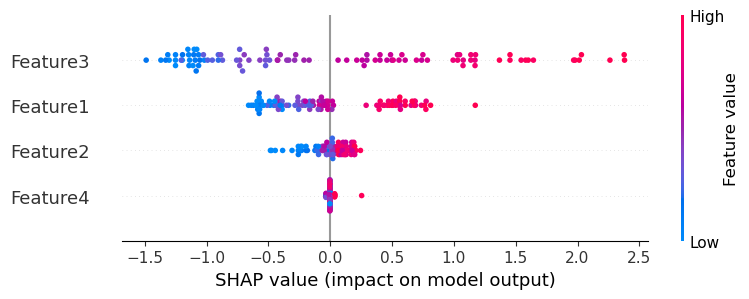

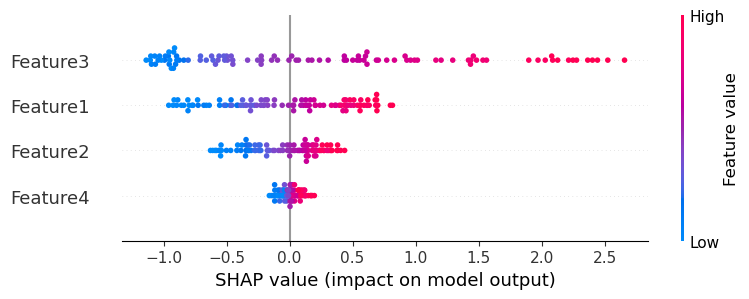

In [57]:
# toy example to check the correctness of the implementation
import shap
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# Simulate an example dataset
np.random.seed(42)
X = np.random.rand(100, 4) # Example dataset with shape (N=100, 4, 56)

explanations = np.zeros((X.shape[-1],X.shape[0]))
for target_feat in range(X.shape[-1]):
    explanations[target_feat, :] = shapley_value(X, target_feat,non_linear_f)
explanations = np.transpose(explanations, (1,0))
print(explanations.shape)

y=non_linear_f(X)
feature_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4']
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X, y)

explainer = shap.TreeExplainer(tree_model, X)
shap_values = explainer.shap_values(X)
print("SHAP package Shapley values:", shap_values.shape)

shap.summary_plot(shap_values, X, feature_names=feature_names)
shap.summary_plot(explanations, X, feature_names=feature_names)

In [200]:
## GNN graphs loading
import torch
import torchdrug as td
import os
import sys
sys.path.append('/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/HDXRank')
from tqdm import tqdm
from GearNet import GearNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = '/home/lwang/models/HDX_LSTM/data/Latest_set/graph_ensemble_simpleGearNet/cluster1_8A_manual_rescale'
graphs = []
for i, file in tqdm(enumerate(os.listdir(data_dir))):
    if file.endswith('.pt'):
        graphs.extend(torch.load(os.path.join(data_dir, file)))
print(len(graphs))

## GNN model loading
model_fpath = f'/home/lwang/models/HDX_LSTM/results/240918_GVP/model_GN56_cluster1_8A_manual_rescale_v0_epoch99.pth'
model = GearNet(56, hidden_dims = [512,512,512], num_relation=7, batch_norm=True, concat_hidden=True, readout='sum', activation = 'relu', short_cut=True)
model_state_dict = torch.load(model_fpath, map_location=device)
model_state_dict = model_state_dict['model_state_dict'] # add if saved as checkpoint
model.load_state_dict(model_state_dict)

114it [00:16,  6.84it/s]

11647


<All keys matched successfully>

In [ ]:
import random

random.seed(42)
sample_graphs = random.sample(graphs, 100)
sample_node_embedding = [graph.residue_feature.float() for graph in sample_graphs]
GLOBAL_FEATURE_MEANS = torch.mean(torch.cat(sample_node_embedding), dim=0)
print(len(sample_graphs))
print(GLOBAL_FEATURE_MEANS)

GNN_feats = {
            "MSA": list(range(0, 30)),
            "HDMD": list(range(30, 35)),
            "Residue polarity": list(range(35, 39)),
            "Residue charge": list(range(39, 40)),
            "SASA": list(range(40, 41)),
            "HSE": list(range(41, 44)),
            "Dihedrals": list(range(44, 50)),
            "Orientations": list(range(50, 56))
            }

def shapley_value_GNN(graph, node_embedding, target_feat, model, GNN_feats, GLOBAL_FEATURE_MEANS):
    N_features = node_embedding[0].shape[-1]
    N_wo_j = list(GNN_feats.keys())
    N_wo_j.remove(target_feat)

    S_coalitions = generate_coalitions(N_wo_j)
    S_probs = {S_len: compute_coalition_prob(S_len, N_features) for S_len in range(N_features)}

    shapley = 0
    model.eval()
    for S in S_coalitions:
        # convert S to real feature index
        real_S = []
        for feat in S:
            real_S.extend(GNN_feats[feat])
        real_S_plusJ = real_S + GNN_feats[target_feat]

        masked_X1 = mask_features_with_mean(node_embedding, real_S, baseline='dataset', GLOBAL_FEATURE_MEANS=GLOBAL_FEATURE_MEANS)
        masked_X2 = mask_features_with_mean(node_embedding, real_S_plusJ, baseline='dataset', GLOBAL_FEATURE_MEANS=GLOBAL_FEATURE_MEANS)
        masked_X1_tensor = torch.tensor(masked_X1).to(device)
        masked_X2_tensor = torch.tensor(masked_X2).to(device)

        marginal_contribution = model(graph, masked_X2_tensor).cpu().detach().numpy() - model(graph, masked_X1_tensor).cpu().detach().numpy()
        shapley += marginal_contribution * S_probs[len(S)]
    return shapley.item()


100
tensor([0.7317, 0.9032, 0.8072, 0.7698, 0.8146, 0.8071, 0.8448, 0.7510, 0.7830,
        0.7059, 0.8221, 0.8028, 0.8445, 0.7681, 0.7860, 0.7166, 0.7471, 0.7276,
        0.9310, 0.8441, 0.0667, 0.8660, 0.8751, 0.4982, 0.3463, 0.5710, 0.1726,
        0.9417, 0.3259, 0.4377, 0.3996, 0.4109, 0.5886, 0.6781, 0.5106, 0.5001,
        0.2952, 0.1591, 0.0456, 0.5954, 0.1863, 0.0000, 0.0000, 0.0000, 0.5236,
        0.5435, 0.0086, 0.1186, 0.5292, 0.4843, 0.5156, 0.4999, 0.4917, 0.4899,
        0.5066, 0.5110])


In [ ]:
explanations = np.zeros((len(sample_graphs), len(GNN_feats.keys())))
for i in range(len(sample_graphs)):
    for j, feat_exp in enumerate(GNN_feats.keys()):
        explanations[i, j] = shapley_value_GNN(sample_graphs[i], sample_node_embedding[i], feat_exp, model, GNN_feats, GLOBAL_FEATURE_MEANS)
print(explanations[0,:])

/tmp/ipykernel_136991/1531994968.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  explanations[0, j] = shapley_value_GNN(sample_graphs[0], sample_node_embedding[0], feat_exp, model, GNN_feats, GLOBAL_FEATURE_MEANS)


[ 2.02425453e-03 -1.69657113e-04  2.49444717e-03 -1.67737715e-04
  2.51673919e-04  0.00000000e+00 -1.61438738e-03 -1.10974088e-05]


In [58]:
explanations = np.load('/home/lwang/models/HDX_LSTM/results/241110_GearNet/SHAP_values_GearNet_cluster1_8A_manual_rescale_v0_epoch99.npy')
print(explanations.shape)

(2000, 8)


MSA                 1.370958e-03
SASA                7.564643e-04
Residue polarity    6.549001e-04
Dihedrals           5.592781e-04
HDMD                3.217187e-04
Orientations        2.176076e-04
Residue charge      6.593868e-05
HSE                 8.618072e-11
dtype: float64
Index(['MSA', 'SASA', 'Residue polarity', 'Dihedrals', 'HDMD', 'Orientations',
       'Residue charge', 'HSE'],
      dtype='object')


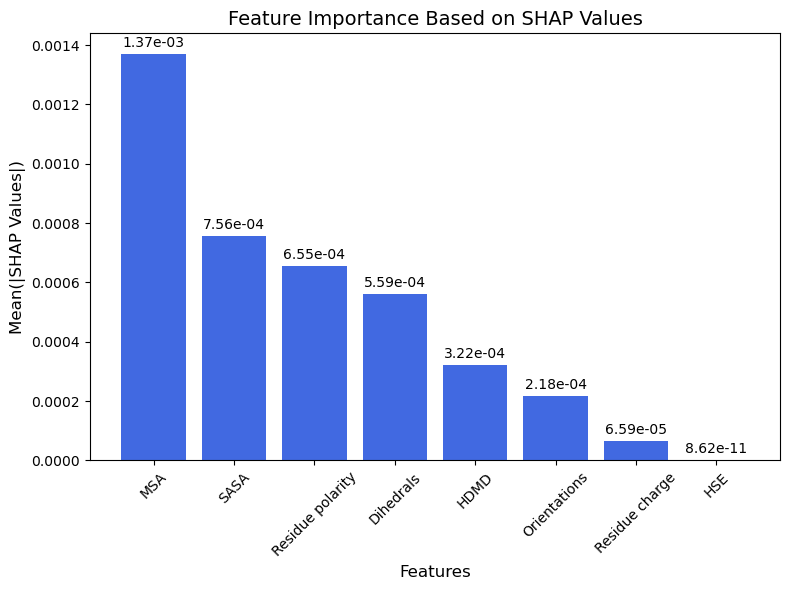

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

GNN_feats = {
            "MSA": list(range(0, 30)),
            "HDMD": list(range(30, 35)),
            "Residue polarity": list(range(35, 39)),
            "Residue charge": list(range(39, 40)),
            "SASA": list(range(40, 41)),
            "HSE": list(range(41, 44)),
            "Dihedrals": list(range(44, 50)),
            "Orientations": list(range(50, 56))
            }

explanation_df = pd.DataFrame(explanations, columns=GNN_feats.keys())

abs_mean = explanation_df.abs().mean()  # Mean of absolute SHAP values
std_dev = explanation_df.abs().std()   # Standard deviation of absolute SHAP values
abs_max = explanation_df.abs().max()  # Sum of absolute SHAP values

sorted_features = abs_mean.sort_values(ascending=False)
sorted_std_dev = std_dev[sorted_features.index]
print(sorted_features)
print(sorted_features.index)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x=sorted_features.index, height=sorted_features,
               capsize=5, color="royalblue", alpha=1, label=list(sorted_features.values))
ax.bar_label(bars, padding=3, fmt='%.2e')

plt.xlabel("Features", fontsize=12)
plt.ylabel("Mean(|SHAP Values|)", fontsize=12)
plt.title("Feature Importance Based on SHAP Values", fontsize=14)
plt.xticks(rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 0.0015)
plt.tight_layout()
plt.show()
#plt.savefig('/home/lwang/models/HDX_LSTM/results/241110_GearNet/SHAP_values_GearNet_feature.png', dpi=300)
